In [19]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import (
    set_seaborn_style,
    days_between_dates,
    generate_wordcloud,
    get_positive_adjectives,
    is_reaction,
    get_reaction_type
)
import emoji
from matplotlib.dates import MonthLocator, DateFormatter
from wordcloud import WordCloud
import july
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

# Visualization theme
USER_COLORS = ['#FFBDE6', '#AEE2FF']
COMBINED_COLOR = '#FFB534'
FONT_FAMILY = 'sans-serif'
BACKGROUND_COLOR = '#352F44'
GRID_COLOR = '#5C5470'
TEXT_COLOR = '#eee'

# Apply theme
set_seaborn_style(
    font_family= FONT_FAMILY,
    background_color=BACKGROUND_COLOR,
    grid_color = GRID_COLOR,
    text_color=TEXT_COLOR
)
sns.set_context(rc = {'patch.linewidth': 0.0})

# Load data
df = pd.read_csv('../data/cleaned_texts.csv')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\scsmi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\scsmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\scsmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


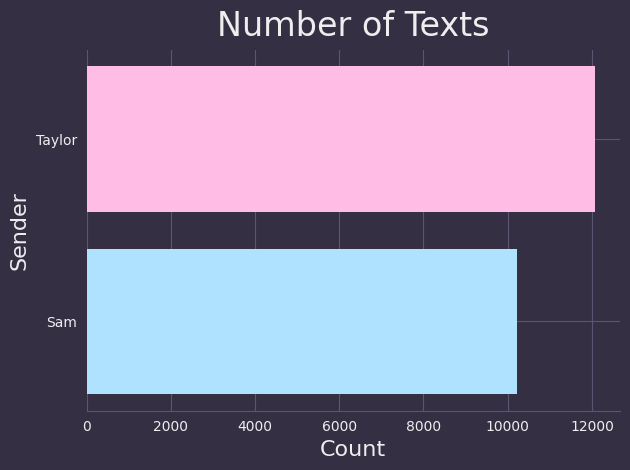

In [2]:
# Number of texts
text_counts = df['Sender'].value_counts()

# Plot
plt.barh(text_counts.index, text_counts.values, color=USER_COLORS)
plt.title('Number of Texts', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

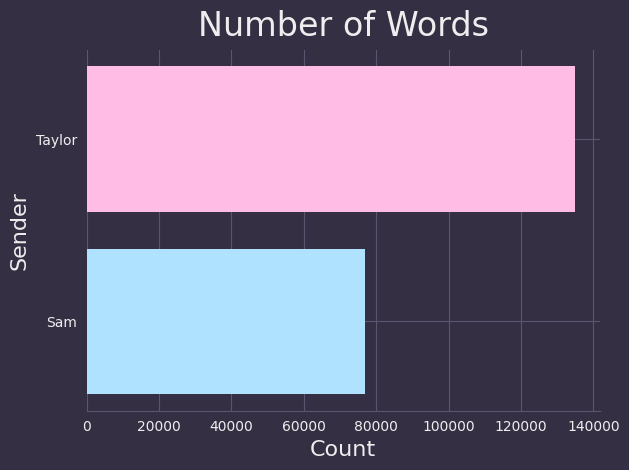

In [3]:
# Total number of words sent
df_word_num = df.groupby('Sender')['num_words'].sum().reset_index()
df_word_num = df_word_num.sort_values(by='num_words', ascending=False)

# Plotting the bar plot
plt.barh(df_word_num['Sender'], df_word_num['num_words'], color=USER_COLORS)
plt.title('Number of Words', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [4]:
# Text Word Length Statistics
print('Number of Words per Text\n------------------------')
df.groupby('Sender')['num_words'].describe()

Number of Words per Text
------------------------


,count,mean,std,min,25%,50%,75%,max
Sender,,,,,,,,
Sam,10221.0,7.519616,6.825612,1.0,3.0,6.0,11.0,146.0
Taylor,12064.0,11.188909,13.352764,0.0,4.0,8.0,14.0,234.0


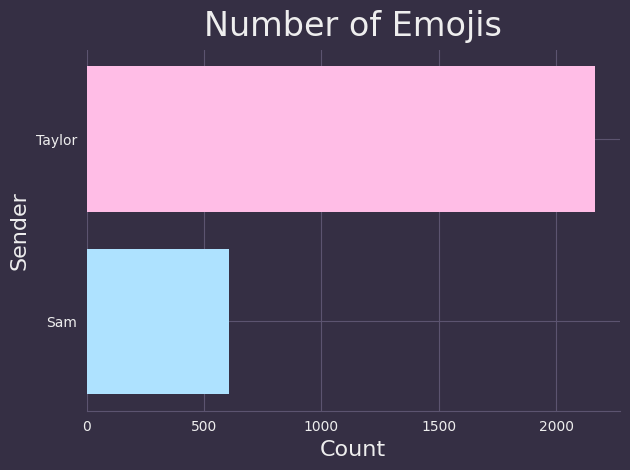

In [5]:
# Total Number of Emojis
total_emoji_counts = df.groupby('Sender')['emoji_num'].sum().reset_index()
total_emoji_counts = total_emoji_counts.sort_values(by='emoji_num', ascending=False)

plt.barh(total_emoji_counts['Sender'], total_emoji_counts['emoji_num'], color=USER_COLORS)
plt.title('Number of Emojis', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [6]:
# List of all emojis
special_emojis = [':)', ':/', ':(', '◡̈']
emojis = special_emojis + [em['en'] for em in emoji.EMOJI_DATA.values()]

# Find emojis each used
emoji_counts = {}
for i, row in df.iterrows():
    sender = row['Sender']
    msg = row['Text']

    if not sender in emoji_counts.keys():
        emoji_counts[sender] = {}

    for em in emojis:
        count = str(msg).count(em)
        if (count > 0):
            if em in emoji_counts[sender].keys():
                emoji_counts[sender][em] += count
            else:
                emoji_counts[sender][em] = count

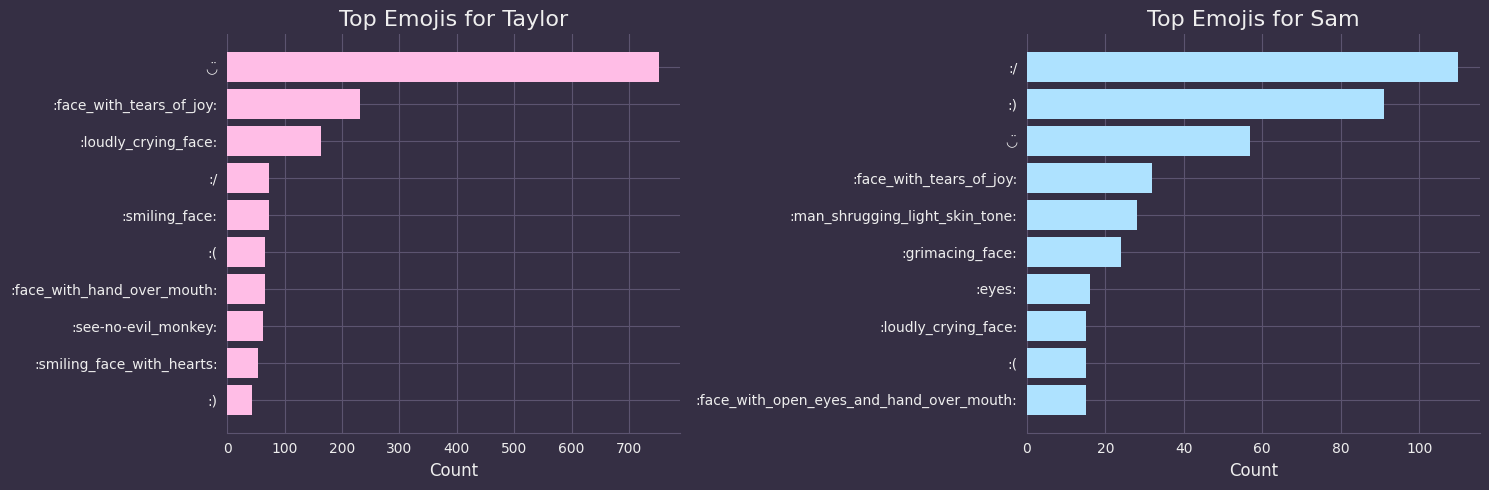

In [7]:
# Find top emojis
TOP_EMOJI_NUM = 10
top_emojis = {}
for sender in emoji_counts.keys():
    top_emojis[sender] = {}
for sender in emoji_counts.keys():
    top_emojis[sender] = dict(sorted(emoji_counts[sender].items(), key=lambda x: x[1], reverse=True)[:TOP_EMOJI_NUM])

# Plots
num_senders = len(top_emojis.keys())
fig, axs = plt.subplots(1, num_senders, figsize=(15, 5))
for i, sender in enumerate(top_emojis.keys()):
    ems = [em for em in top_emojis[sender].keys()]
    counts = list(top_emojis[sender].values())
    
    bars = axs[i].barh(ems, counts, color=USER_COLORS[i])
    axs[i].set_title('Top Emojis for {}'.format(sender), fontsize=16)
    axs[i].set_xlabel('Count', fontsize=12)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

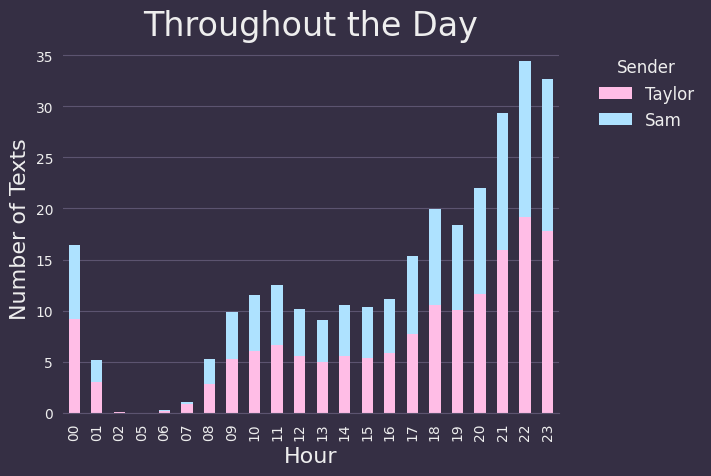

In [8]:
# Texts throughout the day
text_hours = {}
for i, row in df.iterrows():
    sender = row['Sender']
    hour = row['Date'][-5:-3]

    if not sender in text_hours.keys():
        text_hours[sender] = {}

    if not hour in text_hours[sender]:
        text_hours[sender][hour] = 1
    else:
        text_hours[sender][hour] += 1

# Calculate average number of texts at each hour
df_hours = pd.DataFrame(text_hours).fillna(0).sort_index()
first_date = df.iloc[0]['Date']
last_date = df.iloc[-1]['Date']
num_days = days_between_dates(first_date, last_date)
df_hours.iloc[:, 0:] = df_hours.iloc[:, 0:] / num_days

# Plot
df_hours.plot(kind='bar', stacked=True, color=USER_COLORS)
plt.title('Throughout the Day', fontsize=24)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Texts', fontsize=16)
plt.grid(axis='x', alpha=0)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left', 
           fontsize=12, title_fontsize=12)
plt.show()

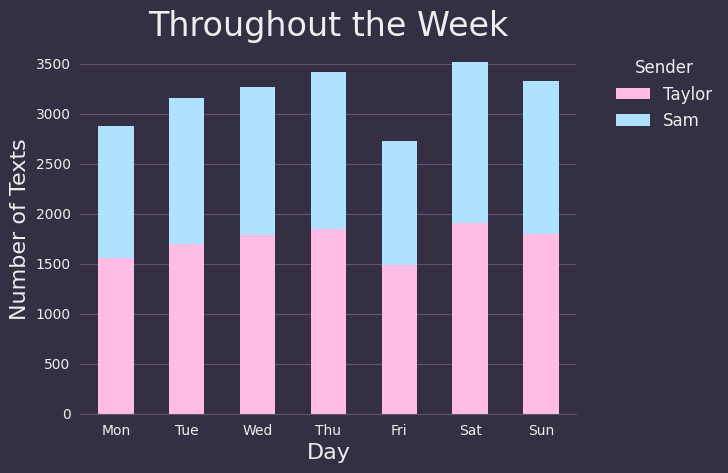

In [9]:
text_days = {}
for i, row in df.iterrows():
    sender = row['Sender']
    day = row['Date'][0:3]

    if not sender in text_days.keys():
        text_days[sender] = {}

    if not day in text_days[sender]:
        text_days[sender][day] = 1
    else:
        text_days[sender][day] += 1

days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
names = list(text_days.keys())
ordered_day_counts = [list(text_days[name][day] for day in days_of_week) for name in names]

df_days = pd.DataFrame(columns=names)
for i, name in enumerate(names):
    df_days[name] = ordered_day_counts[i]

df_days.plot(kind='bar', stacked=True, color=USER_COLORS)
plt.title('Throughout the Week', fontsize=24)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Number of Texts', fontsize=16)
plt.xticks(range(len(days_of_week)), days_of_week, rotation=0)
plt.grid(axis='x', alpha=0)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left', 
           fontsize=12, title_fontsize=12)
plt.show()

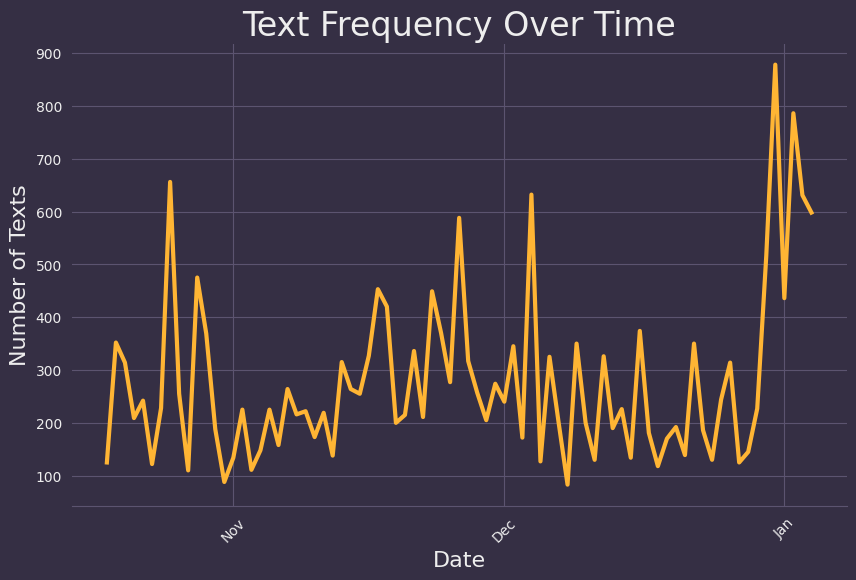

In [6]:
# Number of texts sent each day
df['Date'] = pd.to_datetime(df['Date'], format='%A, %b %d, %Y %H:%M')
daily_texts_df = df.groupby(df['Date'].dt.date).size().reset_index(name='Count')
daily_texts_df = daily_texts_df[:-1]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_texts_df['Date'], daily_texts_df['Count'], color=COMBINED_COLOR, lw=3)

months = MonthLocator()
monthsFmt = DateFormatter("%b")

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.xticks(rotation=45)
plt.title('Text Frequency Over Time', fontsize=24)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Texts', fontsize=16)
plt.show()

<AxesSubplot: title={'center': 'How Often Do You Text?'}>

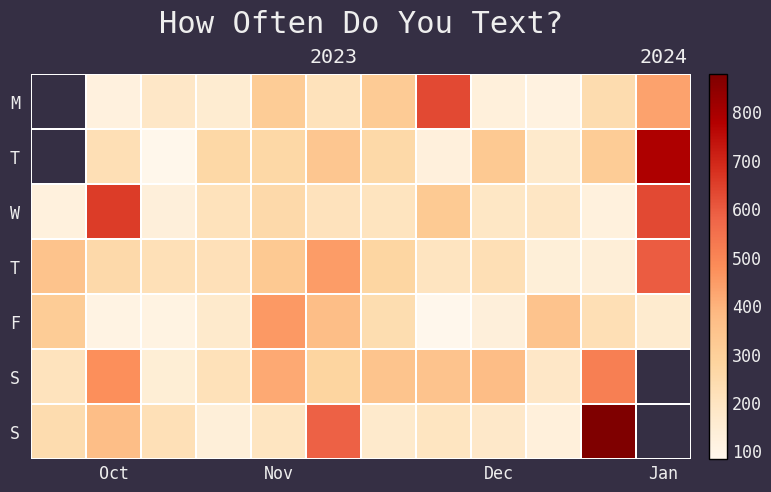

In [47]:
# Heatmap
df['Date'] = pd.to_datetime(df['Date'], format='%A, %b %d, %Y %H:%M')
daily_texts_df = df.groupby(df['Date'].dt.date).size().reset_index(name='Count')
july.heatmap(dates=daily_texts_df.Date, data=daily_texts_df.Count, 
             cmap='OrRd',
             month_grid=False,
             colorbar=True,
             title="How Often Do You Text?", titlesize=22)

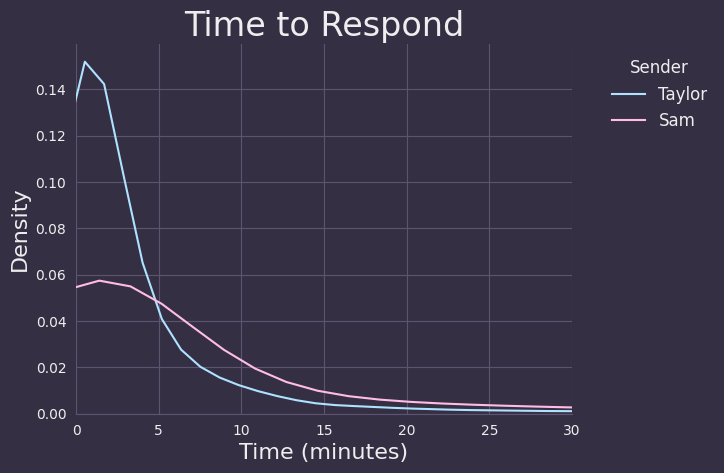

,count,mean,std,min,25%,50%,75%,max
Sender,,,,,,,,
Sam,4572.0,10.709318,27.975865,0.0,0.0,1.0,7.0,344.0
Taylor,4625.0,3.668541,9.525427,0.0,0.0,1.0,3.0,221.0


In [11]:
# Response times
latest_time = None
latest_sender = None
response_times = {}
for i, row in df.iterrows():
    time = row['Date']
    sender = row['Sender']

    if i == 0:
        latest_time = time
        latest_sender = sender
        continue

    if sender != latest_sender:
        time_to_respond = time - latest_time
        latest_sender = sender
        latest_time = time

        # Don't consider "goodnight" texts (> 6 hours)
        if time_to_respond.total_seconds() < 6 * 3600:
            if not sender in response_times.keys():
                response_times[sender] = []
            response_times[sender].append(time_to_respond)

# Organize data in dataframe from plotting
pairs = [(sender, timestamp) for sender, timestamps in response_times.items() for timestamp in timestamps]
df_response_times = pd.DataFrame(pairs, columns=['Sender', 'response_time'])
df_response_times['response_min'] = [time.total_seconds() / 60 for time in df_response_times['response_time']]

# KDE Plot
for sender, color in reversed(list(zip(df_response_times['Sender'].unique(), USER_COLORS))):
    sns.kdeplot(data=df_response_times[df_response_times['Sender'] == sender], x='response_min', label=sender, color=color)
plt.title('Time to Respond', fontsize=24)
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left', 
           fontsize=12, title_fontsize=12)
plt.xlim(0, 30)
plt.show()

# Statistics
df_response_times.groupby('Sender')['response_min'].describe()

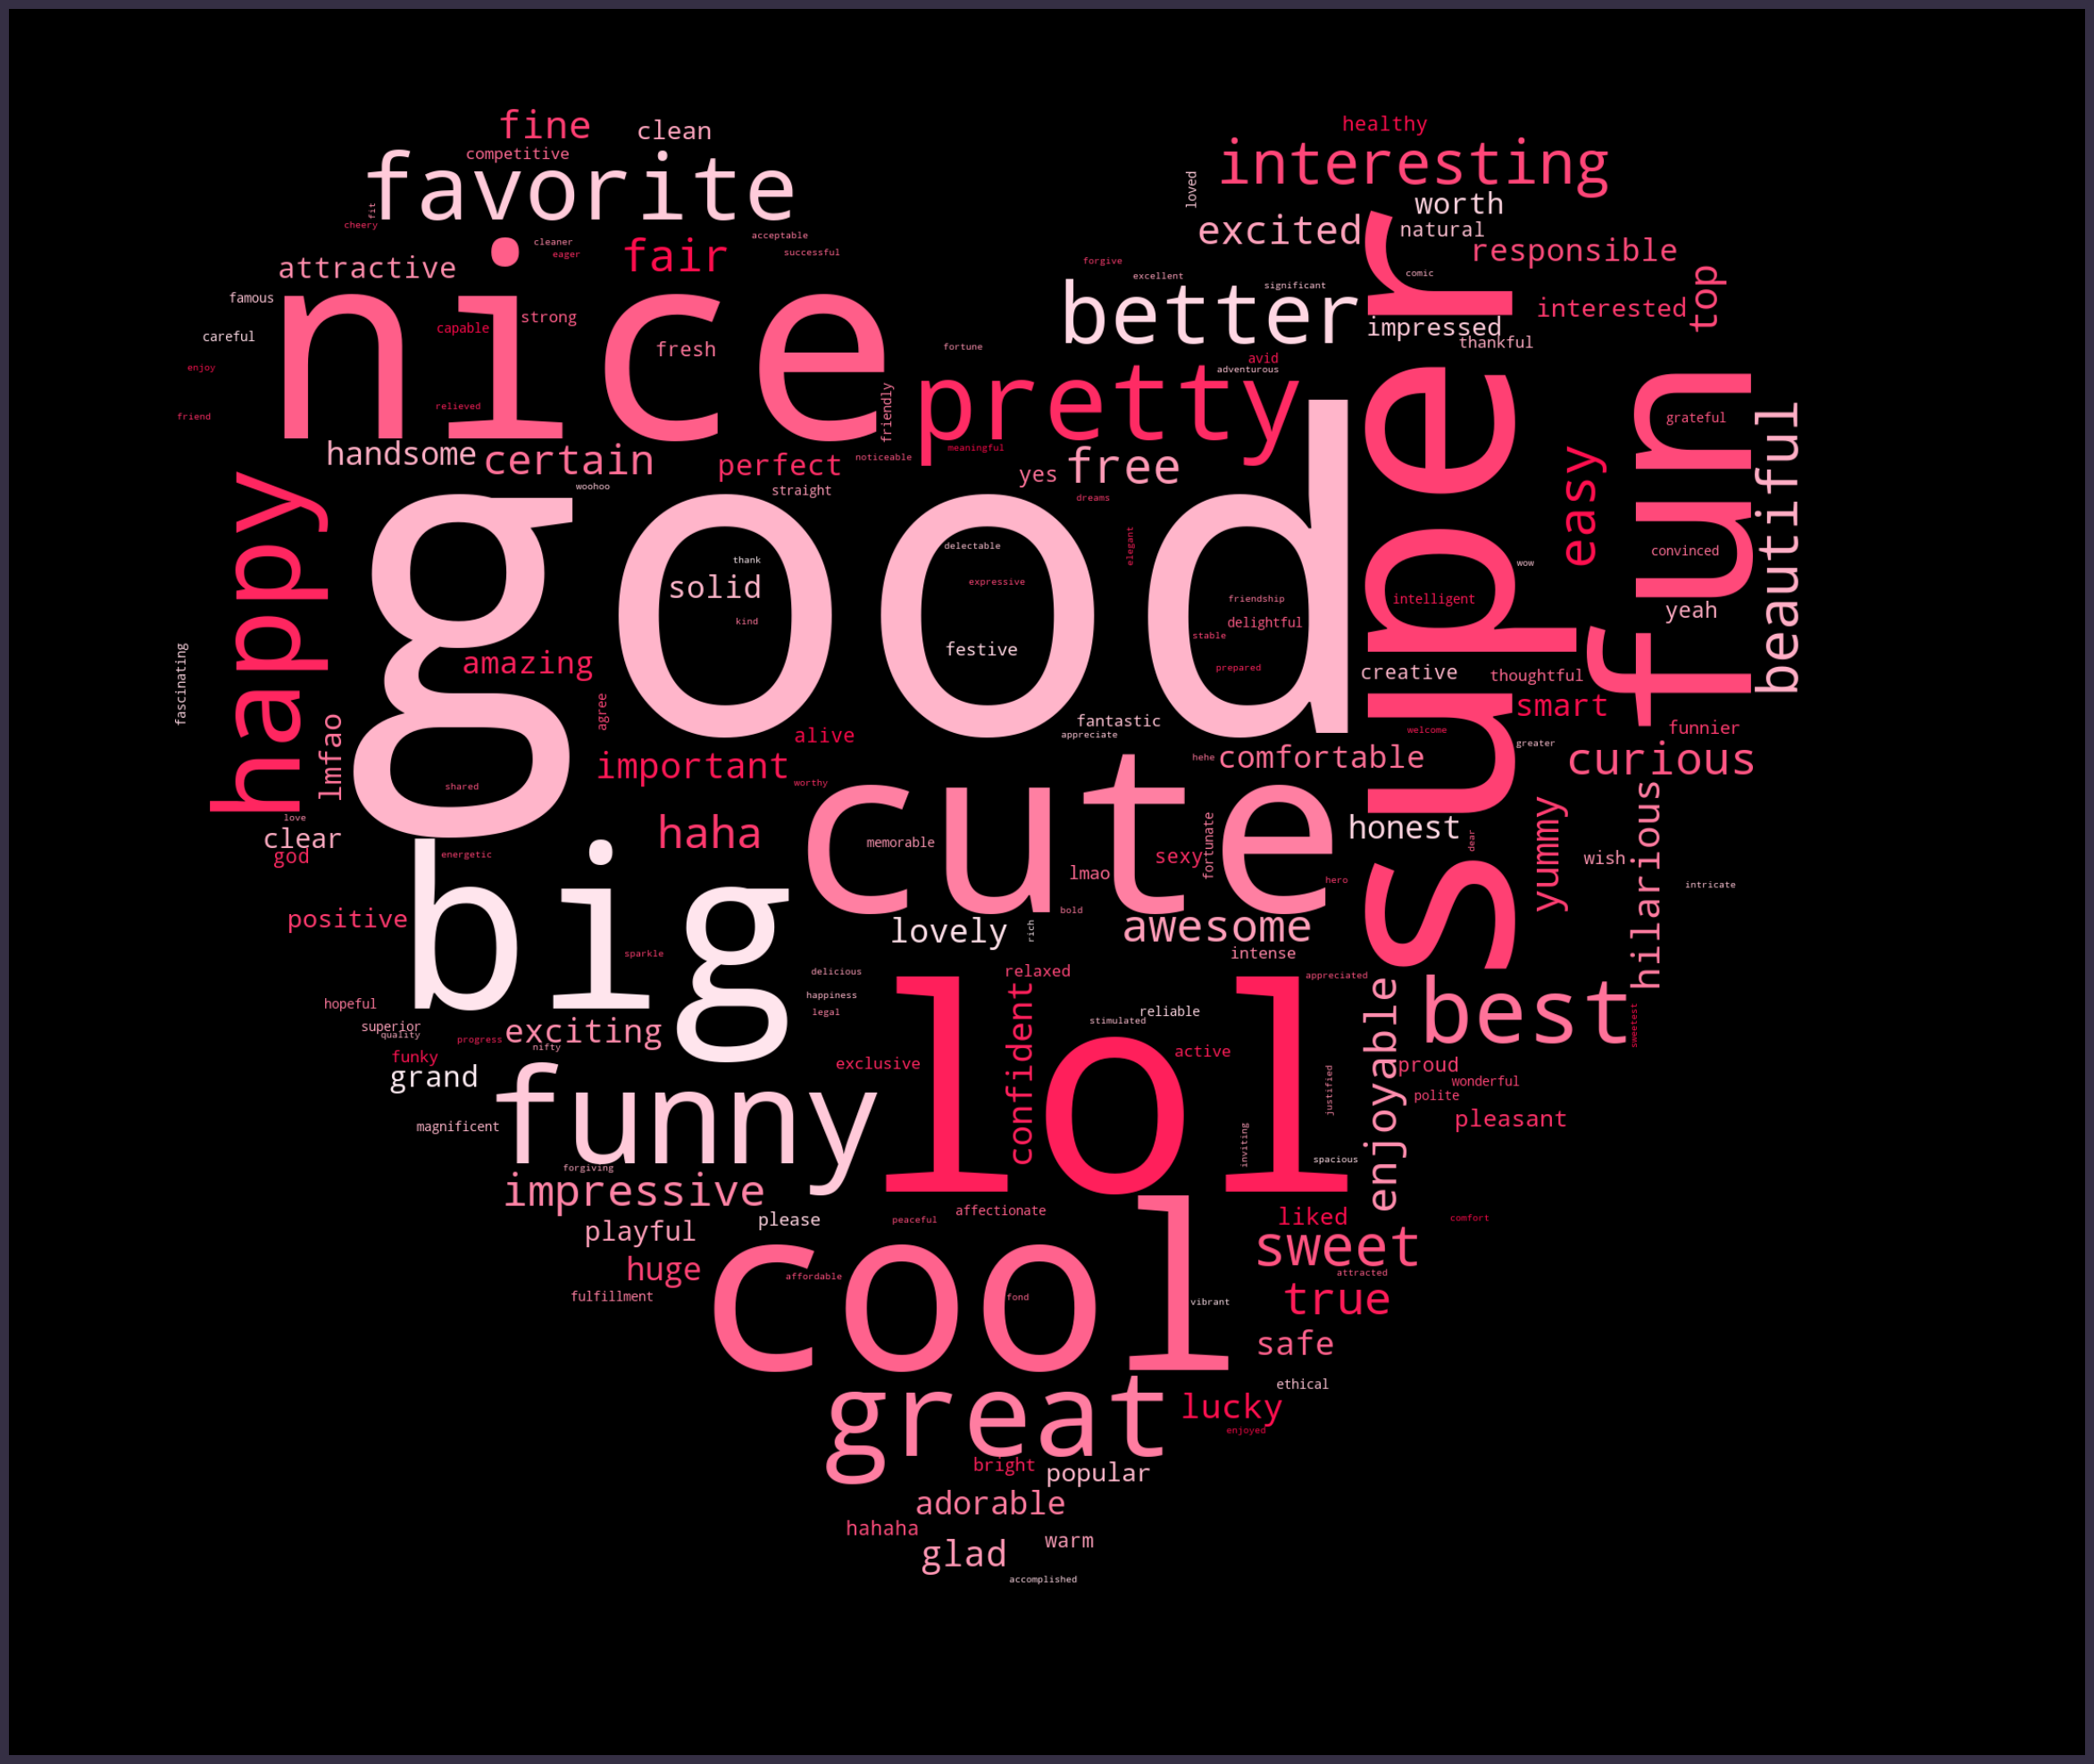

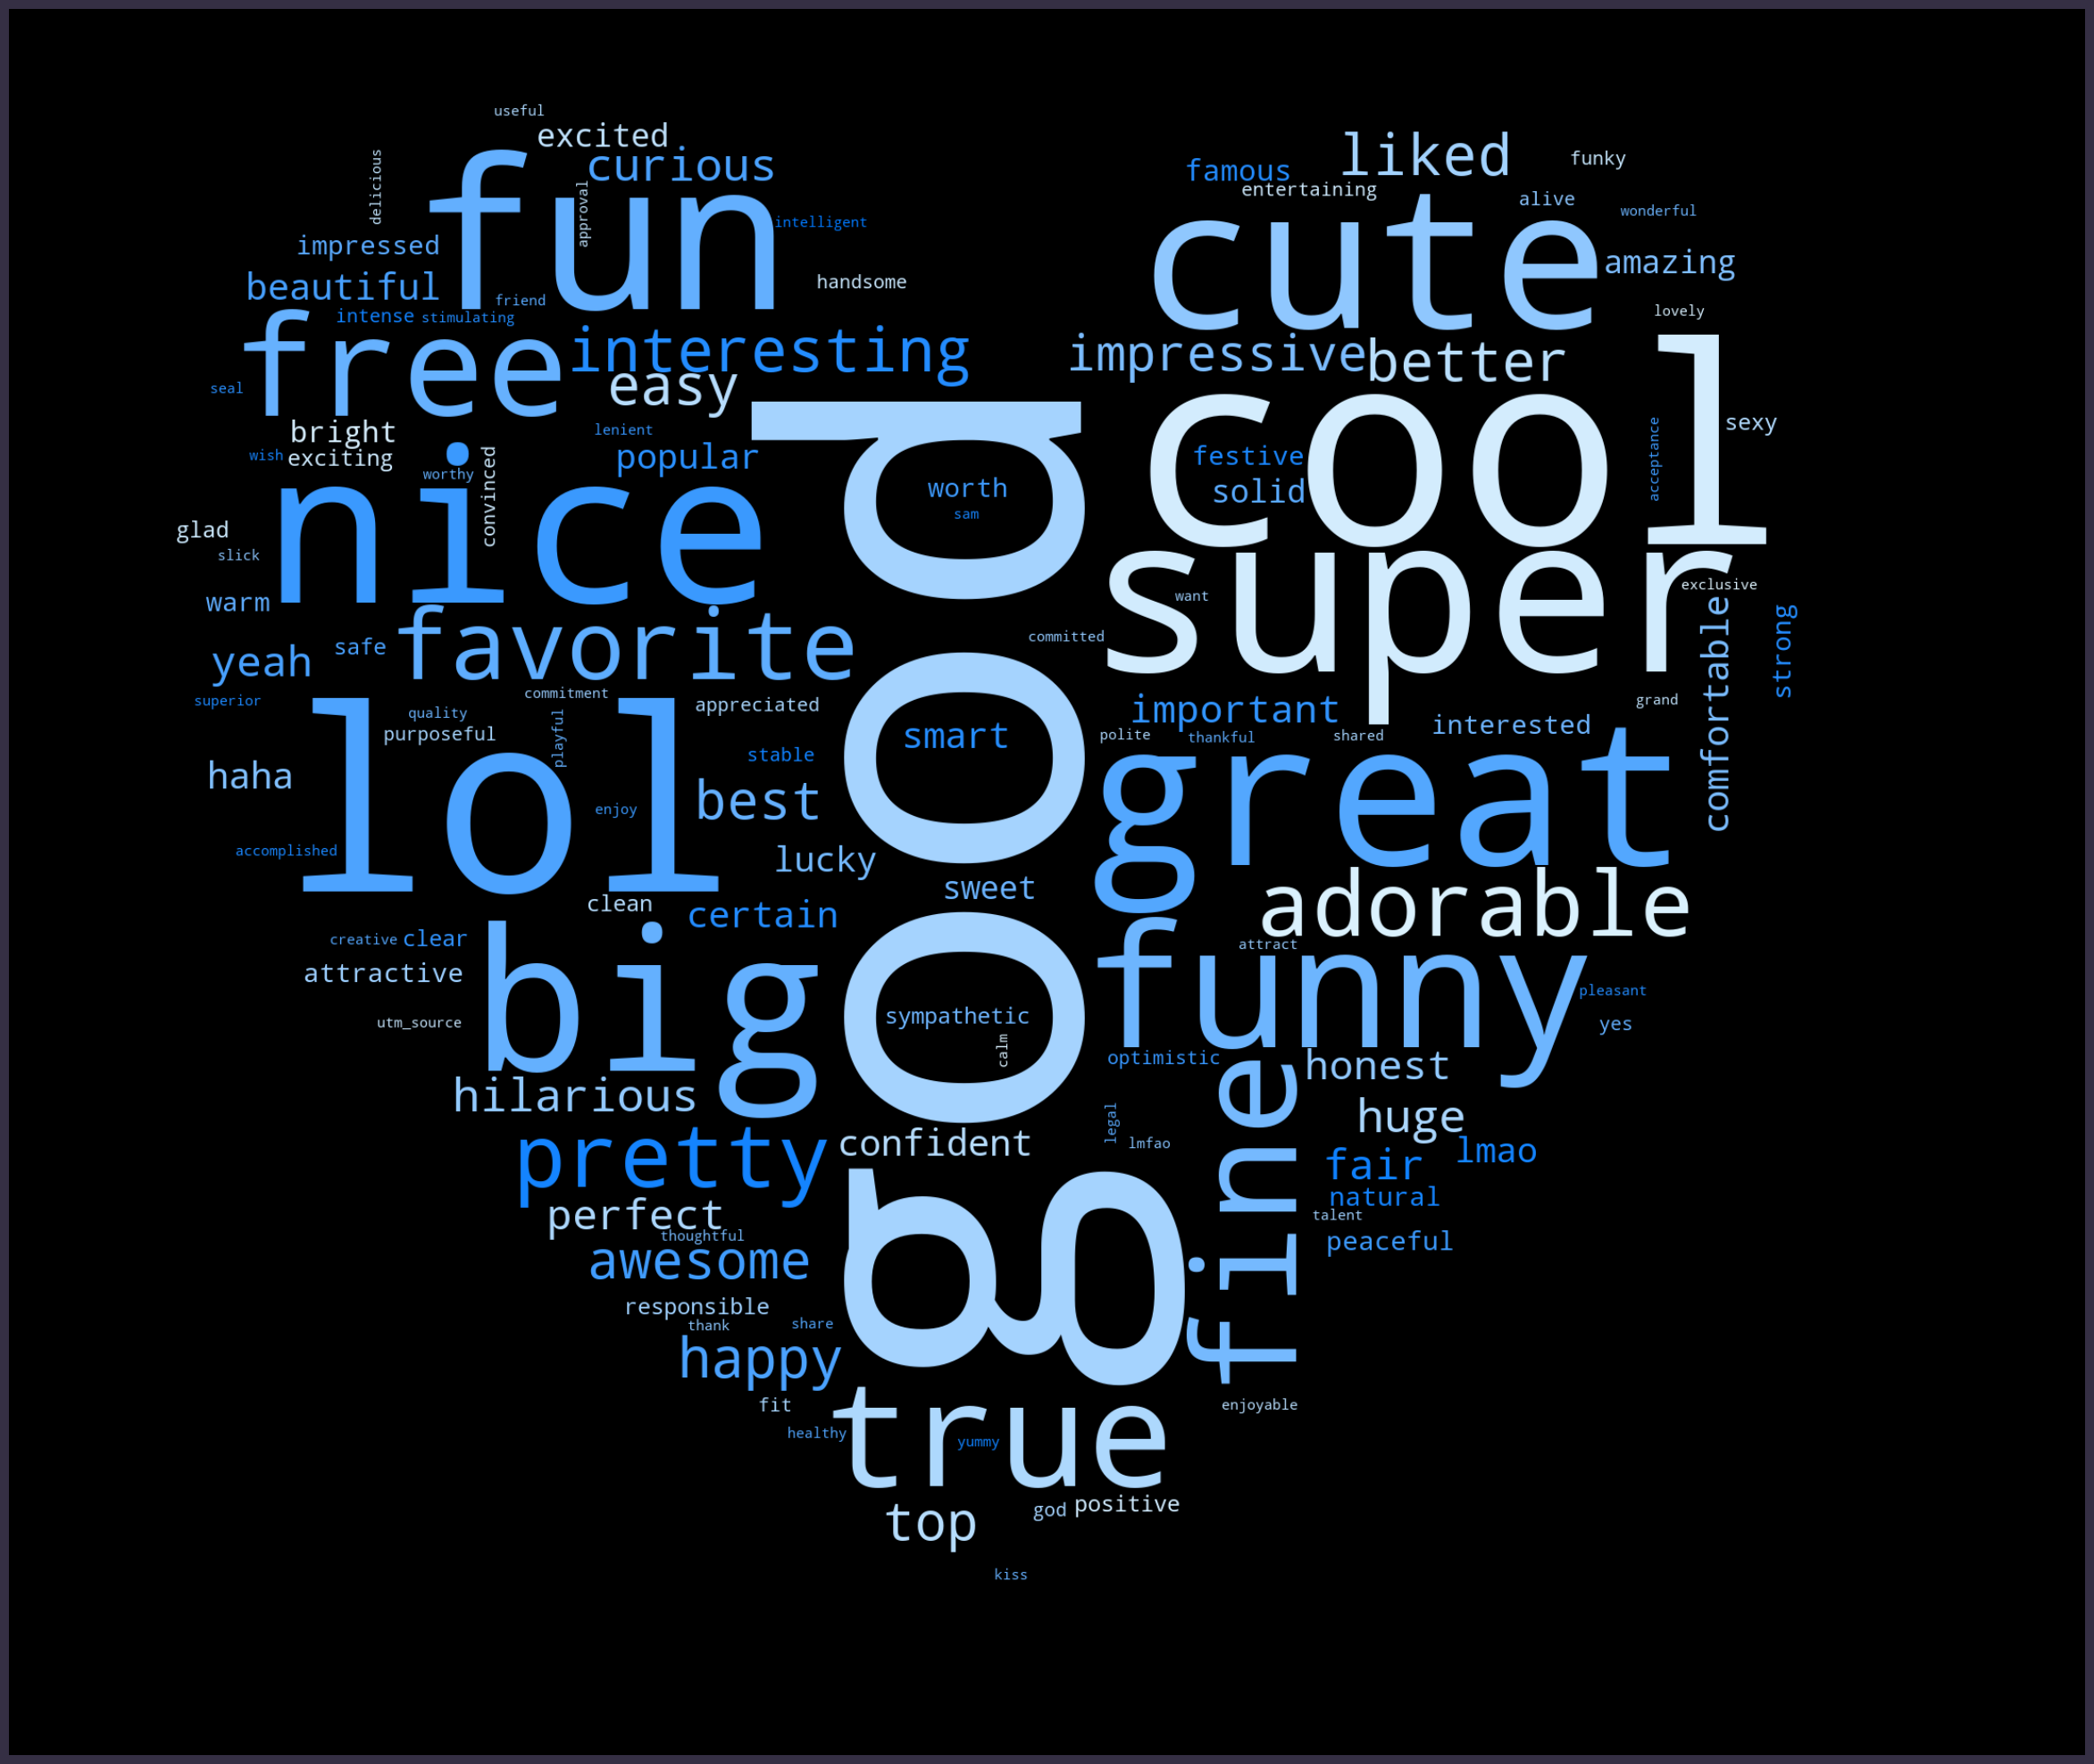

In [12]:
# Word clouds
text_corpus = {}
for i, row in df.iterrows():
    msg = row['Text']
    sender = row['Sender']

    if not sender in text_corpus.keys():
        text_corpus[sender] = ''

    text_corpus[sender] += ' ' + str(msg)

# Extract positive adjectives
custom_stopwords = ['nan']
stop_words = set(stopwords.words('english') + custom_stopwords)
i = 0
for sender in text_corpus.keys():
    corpus = text_corpus[sender]
    adjectives = get_positive_adjectives(corpus)
    adjectives = [adj.lower() for adj in adjectives if adj.lower() not in stop_words]
    adj_corpus = ' '.join(adjectives)

    if i == 0:
        cols = ['#FFEEF4', '#ff084a']
    else:
        cols = ['#DDF2FD', '#0079FF']
    generate_wordcloud(adj_corpus, '../wordcloud_masks/heart.png', colors=cols)
    i += 1

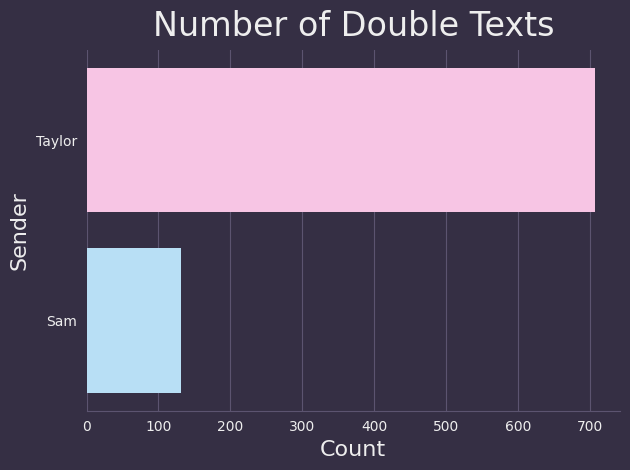

In [13]:
# Number of double texts
df['Date'] = pd.to_datetime(df['Date'], format='%A, %b %d, %Y %H:%M')
df_double_texts = pd.DataFrame(columns=['Sender', 'Date'])
latest_time = None
for i, row in df.iterrows():
    time = row['Date']
    sender = row['Sender']

    if i == 0:
        latest_time = time
        latest_sender = sender
        continue

    if sender == latest_sender:
        time_between_texts = time - latest_time
        latest_time = time
        seconds_to_respond = time_between_texts.total_seconds()
        # Double texts are between 3 minutes and 6 hours
        if seconds_to_respond >= 3 * 60 and seconds_to_respond < 6 * 3600:
            new_row = pd.DataFrame({'Sender': sender, 'Date': [time]})
            df_double_texts = pd.concat([df_double_texts, new_row], ignore_index=True)
    else:
        latest_sender = sender
        latest_time = time

sns.countplot(y='Sender', data=df_double_texts, palette=USER_COLORS)
plt.title('Number of Double Texts', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# Number of double texts per week
min_dates = df_double_texts.groupby('Sender')['Date'].min()
df_double_texts = df_double_texts.merge(min_dates, on='Sender', how='left', suffixes=('', '_min'))
df_double_texts['Week_Number'] = ((df_double_texts['Date'] - df_double_texts['Date_min']).dt.days // 7).astype(int)
weekly_double_texts = df_double_texts.groupby(['Sender', 'Week_Number']).size().reset_index(name='Double_Text_Count')
weekly_double_texts = weekly_double_texts.pivot(index='Sender', columns='Week_Number', values='Double_Text_Count').fillna(0)
weekly_double_texts = weekly_double_texts.sort_index(ascending=False)
weekly_double_texts = weekly_double_texts.iloc[:, :-1]  # don't consider last week (possibly unfinished)
weekly_double_texts

Week_Number,0,1,2,3,4,5,6,7,8,9,10
Sender,,,,,,,,,,,
Taylor,76.0,83.0,66.0,73.0,69.0,65.0,45.0,62.0,54.0,45.0,65.0
Sam,12.0,6.0,5.0,8.0,20.0,10.0,5.0,10.0,11.0,12.0,32.0


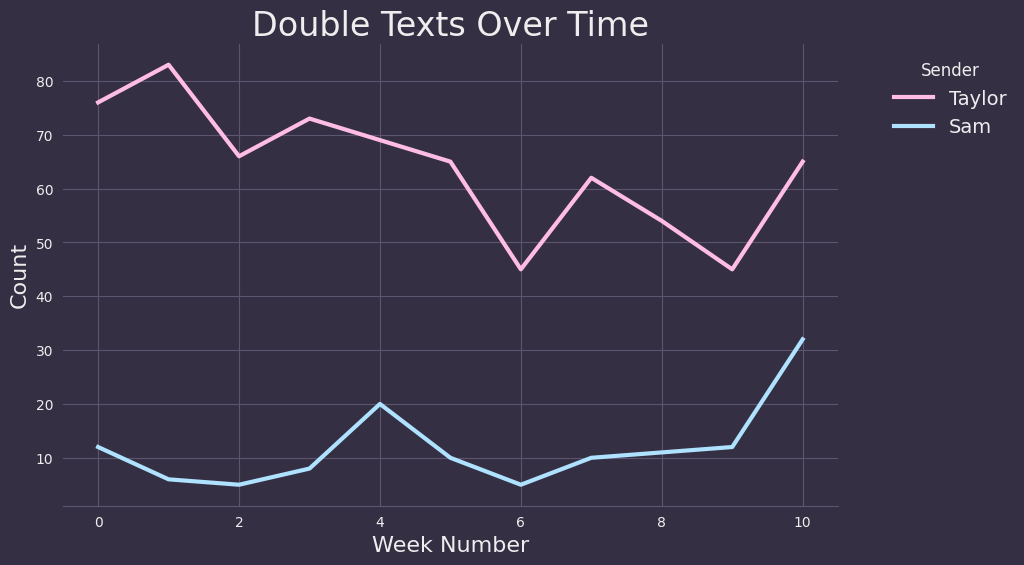

In [15]:
# Plot
plt.figure(figsize=(10, 6))
for sender, color in zip(weekly_double_texts.index, USER_COLORS):
    sns.lineplot(x=weekly_double_texts.columns, y=weekly_double_texts.loc[sender], label=sender, 
                 color=color, lw=3)

plt.title('Double Texts Over Time', fontsize=24)
plt.xlabel('Week Number', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left',
           fontsize=14, title_fontsize=12)
plt.show()

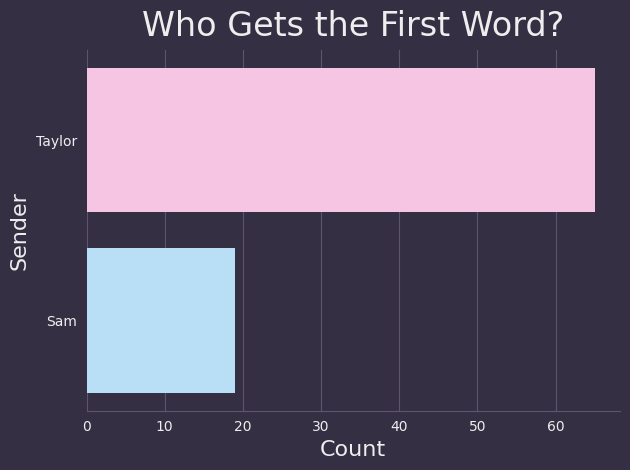

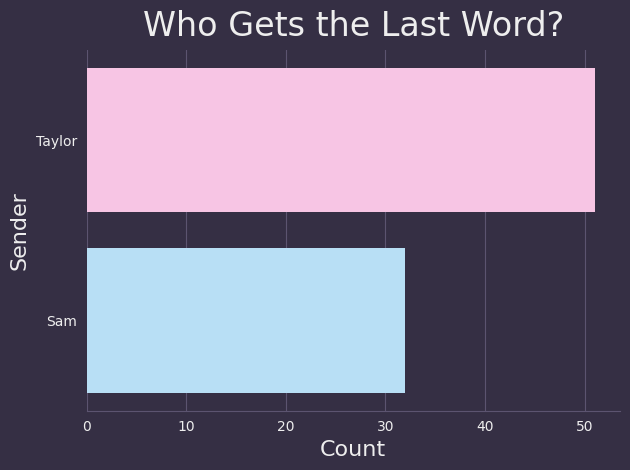

In [16]:
df['Date'] = pd.to_datetime(df['Date'], format='%A, %b %d, %Y %H:%M')
df_first_texts = pd.DataFrame(columns=['Sender', 'Date'])
df_last_texts = pd.DataFrame(columns=['Sender', 'Date'])
latest_time = None
latest_sender = None
for i, row in df.iterrows():
    time = row['Date']
    sender = row['Sender']
    msg = str(row['Text'])

    if i == 0:
        first_text = pd.DataFrame({'Sender': sender, 'Date': [time]})
        df_first_texts = pd.concat([df_first_texts, first_text], ignore_index=True)
        latest_time = time
        latest_sender = sender
        continue

    time_between_texts = time - latest_time
    if time_between_texts.total_seconds() > 6 * 3600:
        first_text = pd.DataFrame({'Sender': sender, 'Date': [time]})
        last_text = pd.DataFrame({'Sender': latest_sender, 'Date': [latest_time]})
        df_first_texts = pd.concat([df_first_texts, first_text], ignore_index=True)
        df_last_texts = pd.concat([df_last_texts, last_text], ignore_index=True)

    if not is_reaction(msg):
        latest_time = time
        latest_sender = sender

df_first_texts = df_first_texts.sort_values(by='Sender', ascending=False)
df_last_texts = df_last_texts.sort_values(by='Sender', ascending=False)

sns.countplot(y='Sender', data=df_first_texts, palette=USER_COLORS)
plt.title('Who Gets the First Word?', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.tight_layout()
plt.show()

sns.countplot(y='Sender', data=df_last_texts, palette=USER_COLORS)
plt.title('Who Gets the Last Word?', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.tight_layout()
plt.show()

{'Taylor': 1027, 'Sam': 473}


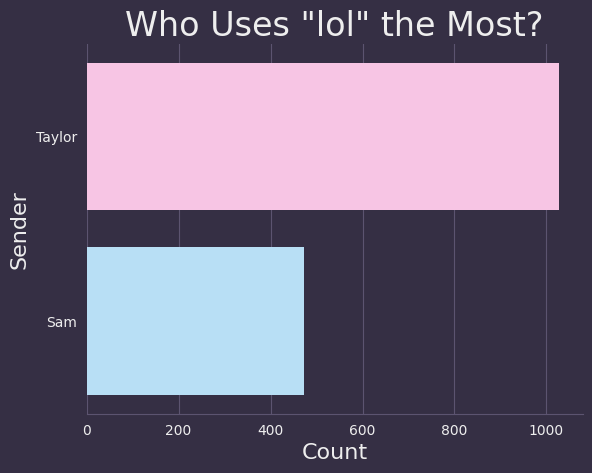

{'Taylor': 25, 'Sam': 93}


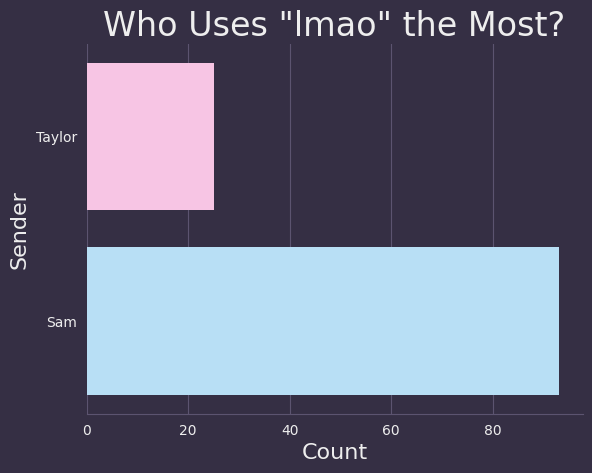

In [21]:
def plot_word_count(word_query):
    # Standardize word query
    original_query = word_query
    word_query = word_query.lower()

    # Combined all messages for each user
    text_corpus = {}
    for i, row in df.iterrows():
        msg = str(row['Text'])
        sender = row['Sender']

        # Skip reactions
        if is_reaction(msg):
            continue

        if not sender in text_corpus.keys():
            text_corpus[sender] = ''

        text_corpus[sender] += ' ' + msg.lower()

    # Count number of times word is used
    word_counts = {}
    for sender in text_corpus.keys():
        words = word_tokenize(text_corpus[sender])
        count = words.count(word_query)
        if not sender in word_counts.keys():
            word_counts[sender] = 0
        word_counts[sender] += count

    print(word_counts)

    # Plot
    sorted_dict = dict(sorted(word_counts.items(), key=lambda item: item[0], reverse=True))
    sns.barplot(y=list(sorted_dict.keys()), x=list(sorted_dict.values()), palette=USER_COLORS)
    plt.title('Who Uses \"{}\" the Most?'.format(original_query), fontsize=24)
    plt.xlabel('Count', fontsize=16)
    plt.ylabel('Sender', fontsize=16)
    plt.show()


query_words = ['lol', 'lmao']
for word in query_words:
    plot_word_count(word)

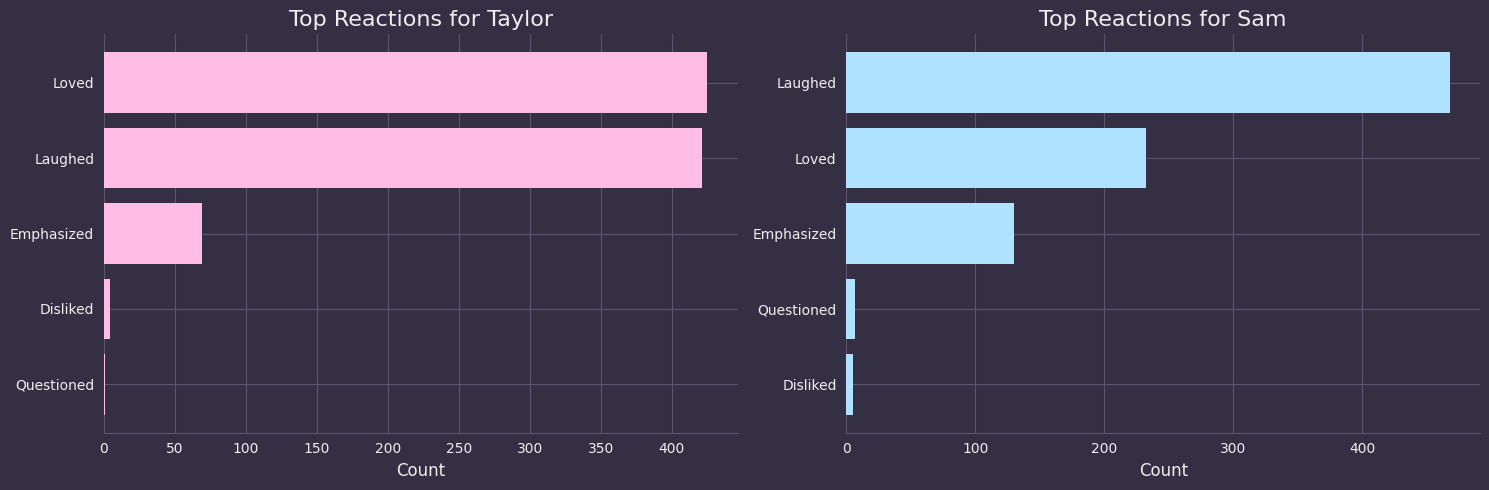

In [18]:
# Top iMessage Reactions
reaction_counts = {}
reactions = df[df['is_reaction'] == True]
for i, row in reactions.iterrows():
    reaction_type = get_reaction_type(str(row['Text']))
    sender = row['Sender']
    
    if not sender in reaction_counts.keys():
        reaction_counts[sender] = {}

    if not reaction_type in reaction_counts[sender].keys():
        reaction_counts[sender][reaction_type] = 0

    reaction_counts[sender][reaction_type] += 1

# Plot
reaction_counts = dict(sorted(reaction_counts.items(), key=lambda item: item[0], reverse=True))
num_senders = len(reaction_counts.keys())
fig, axs = plt.subplots(1, num_senders, figsize=(15, 5))
for i, sender in enumerate(reaction_counts.keys()):
    reaction_counts[sender] = dict(sorted(reaction_counts[sender].items(), key=lambda item: item[1], reverse=True))

    ems = [em for em in reaction_counts[sender].keys()]
    counts = list(reaction_counts[sender].values())
    
    bars = axs[i].barh(ems, counts, color=USER_COLORS[i])
    axs[i].set_title('Top Reactions for {}'.format(sender), fontsize=16)
    axs[i].set_xlabel('Count', fontsize=12)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

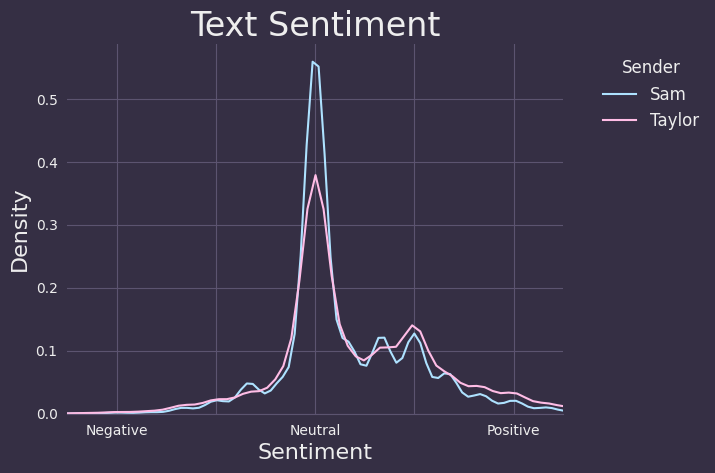

In [19]:
# Plot Text Sentiment
for sender, color in reversed(list(zip(df['Sender'].unique(), USER_COLORS))):
    sns.kdeplot(data=df[df['Sender'] == sender], x='sentiment', label=sender, color=color)
plt.title('Text Sentiment', fontsize=24)
plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left', 
           fontsize=12, title_fontsize=12)
plt.xlim(-7.5, 7.5)
xtick_positions = [-6, -3, 0, 3, 6]
xtick_labels = ['Negative', '', 'Neutral', '', 'Positive']

plt.xticks(xtick_positions, xtick_labels)
plt.show()

In [20]:
# Sentiment statistics
df.groupby('Sender')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
Sender,,,,,,,,
Sam,10221.0,0.956756,2.112744,-15.0,0.0,0.0,2.0,19.0
Taylor,12064.0,1.392987,2.693153,-18.0,0.0,0.0,3.0,28.0


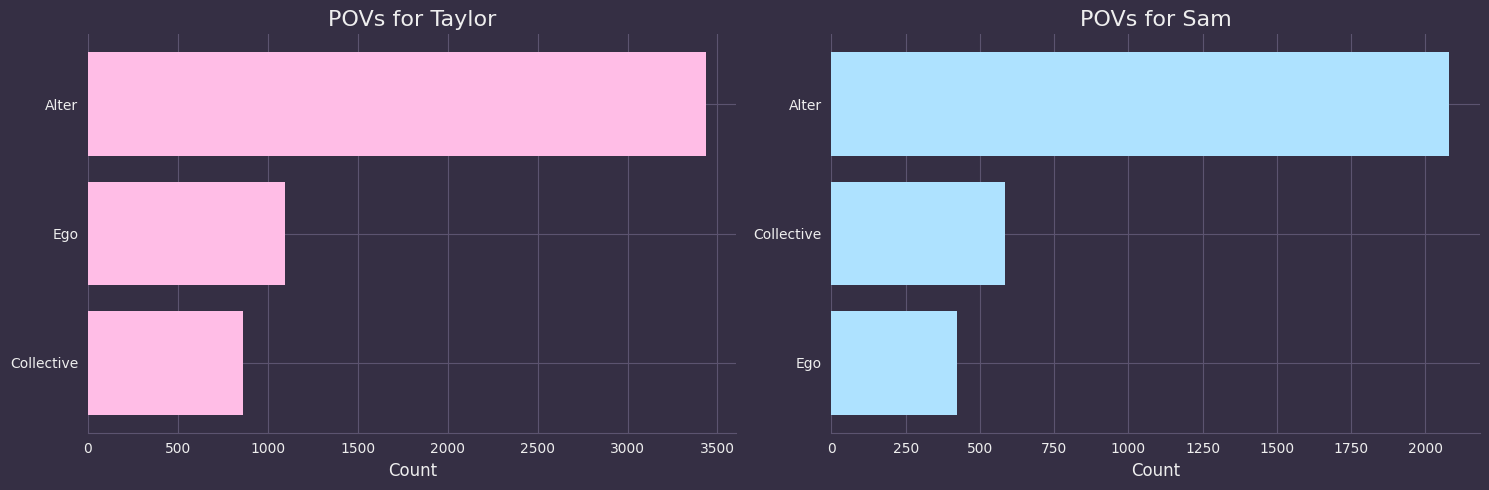

In [9]:
# Ego, Alter, and Collective words
ego_words = ['I', 'me', 'mine', 'myself']
alter_words = ['you', 'your', 'yours', 'yourself', 'yourselves']
collective_words = ['us', 'we', 'our', 'ours', 'ourselves']

# Form text corpus of each user
text_corpus = {}
for i, row in df.iterrows():
    msg = row['Text']
    sender = row['Sender']

    if not sender in text_corpus.keys():
        text_corpus[sender] = ''

    text_corpus[sender] += ' ' + str(msg)

# Count occurences of different POVs
pov_counts = {}
for sender, text in text_corpus.items():
    # Initializing counts
    ego_count = 0
    alter_count = 0
    collective_count = 0

    # Tokenize corpora
    words = word_tokenize(text_corpus[sender])

    # Counting the occurrences of ego, alter, and collective words
    for word in words:
        if word.lower() in ego_words:
            ego_count += 1
        elif word.lower() in alter_words:
            alter_count += 1
        elif word.lower() in collective_words:
            collective_count += 1

    # Storing the counts for each sender
    pov_counts[sender] = {'Ego': ego_count, 'Alter': alter_count, 'Collective': collective_count}

# Plot
num_senders = len(pov_counts.keys())
fig, axs = plt.subplots(1, num_senders, figsize=(15, 5))
for i, sender in enumerate(pov_counts.keys()):
    pov_counts[sender] = dict(sorted(pov_counts[sender].items(), key=lambda item: item[1], reverse=True))

    ems = [em for em in pov_counts[sender].keys()]
    counts = list(pov_counts[sender].values())
    
    bars = axs[i].barh(ems, counts, color=USER_COLORS[i])
    axs[i].set_title('POVs for {}'.format(sender), fontsize=16)
    axs[i].set_xlabel('Count', fontsize=12)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()